In [44]:
import pandas as pd
import requests
import re

In [45]:
import sklearn
import pandas as pd

import wordcloud
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ashmitamukherjee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ashmitamukherjee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [46]:
%%time

# Define the API endpoint and parameters
url = "https://data.cityofchicago.org/resource/cwig-ma7x.json"

# Fetch the total count of records
def get_total_count(url):
    params = {
        "$select": "count(*)"
    }
    response = requests.get(url, params=params)
    data = response.json()
    return int(data[0]['count'])

total_count = get_total_count(url)
print(f"Total number of records available: {total_count:,.0f}")

Total number of records available: 267,004
CPU times: user 33.2 ms, sys: 16.4 ms, total: 49.6 ms
Wall time: 454 ms


In [47]:
%%time

# Fetch data and load it into a pandas DataFrame
def fetch_data(url, params):
    response = requests.get(url, params=params)
    data = response.json()
    return pd.DataFrame(data)

# Set the limit parameter equal to the number of available records
params = {
    "$limit": total_count
}

# Fetch the data and load it into a DataFrame
df = fetch_data(url, params)

print(f'Number of records retrieved: {df.shape[0]:,.0f}')

Number of records retrieved: 267,004
CPU times: user 8.82 s, sys: 2.47 s, total: 11.3 s
Wall time: 1min 13s


In [48]:
df.head(5)

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,...,results,violations,latitude,longitude,location,:@computed_region_awaf_s7ux,:@computed_region_6mkv_f3dw,:@computed_region_vrxf_vc4k,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu
0,2588815,CHICAGO SUB,CHICAGO SUB,2948858,Restaurant,Risk 2 (Medium),4805 W CHICAGO AVE,CHICAGO,IL,60651,...,Pass,"10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE - Comments: OBSERVED NO HAND WASHING SIGNAGE AT HAND WASHING SINK IN WASHROOM. INSTRUCTED MANAGER TO PROVIDE. | 37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER - Comments: OBSERVED FLOUR AND SEASONING OUT OF THE ORIGINAL CONTAINER WITHOUT LABEL CONTAINING THE PRODUCT NAME. INSTRUCTED TO LABEL ALL FOODS AND SPICES WITH COMMON NAME THAT ARE OUT OF THE ORIGINAL CONTAINERS. | 49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Comments: MUST DETAIL CLEAN THE INTERIOR OF ALL COOLERS TO REMOVE SPILLS AND DEBRIS | 49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Comments: OBSERVED THE OUTSIDE OF ALL COOKING EQUIPMENT WITH A BUILD UP OF DIRT AND FOOD SPLATTER, AND GREASE. INSTRUCTED TO CLEAN AND MAINTAIN ALL. | 54. GARBAGE & REFUSE PROPERLY DIS...",41.89489092409063,-87.74608042225631,"{'type': 'Point', 'coordinates': [-87.74608042225631, 41.89489092409063]}",11,4299,26,695,45
1,2588807,CHALMERS ELEMENTARY,CHALMERS ELEMENTARY,22671,School,Risk 1 (High),2745 W Roosevelt Rd (1200S),CHICAGO,IL,60608,...,Fail,"10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE - Comments: 5-202.12(A) OBSERVED THE PRE-K ROOM 107 TOILET ROOM HAND WASHING SINK AT AN INADEQUATE HOT WATER TEMPERATURE OF 70F DURING THE INSPECTION. INSTRUCTED TO MAINTAIN 100F AT ALL HAND WASHING SINKS AT ALL TIMES. BY THE INSPECTION'S END, THE ENGINEER ADJUSTED THE WATER TEMPERATURE, AND THE HOT WATER WAS MAINTAINED AT 100F. PRIORITY VIOLATION 7-38-030(C). | 38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - Comments: 6-501.111 OBSERVED EVIDENCE OF PEST ACTIVITY ON SITE. OBSERVED ABOUT 30 RODENT DROPPINGS IN THE TWO CLOSETS LOCATED IN THE STUDENT CAFETERIA AREA. OBSERVED ABOUT 20 RODENT DROPPINGS UNDER THE PRE-K CLASSROOM HAND WASHING SINK IN ROOM 107 AND ABOUT 10 RODENT DROPPINGS UNDER THE PRE-K CLASSROOM 109. OBSERVED ABO...",41.86640779958484,-87.69526079320438,"{'type': 'Point', 'coordinates': [-87.69526079320438, 41.86640779958484]}",11,14920,30,16,23
2,2588788,AFC SUSHI @ JEWEL OSCO #1296,JEWEL OSCO,2944283,NaN,All,7342 W FOSTER AVE,CHICAGO,IL,60656,...,Not Ready,NaN,41.97454294770947,-87.81134688421793,"{'type': 'Point', 'coordinates': [-87.81134688421793, 41.97454294770947]}",34,4448,36,735,29
3,2588783,JEREZ RESTAURANT SEA FOOD,JEREZ RESTAURANT SEA FOOD,1225507,Restaurant,Risk 1 (High),4803 N PULASKI RD,CHICAGO,IL,60630,...,Out of Business,NaN,41.96833625252941,-87.72788337038888,"{'type': 'Point', 'coordinates': [-87.72788337038888, 41.96833625252941]}",28,21849,14,120,12
4,2588854,DINO'S PIZZA,DINO'S PIZZA,1254,Restaurant,Risk 1 (High),7004-7006 W HIGGINS AVE,CHICAGO,IL,60656,...,Pass,"39. CONTAMINATION PREVENTED DURING FOOD PREPARATION, STORAGE & DISPLAY - Comments: 3-307.11: **C** Miscellaneous Sources of Contamination NOTED NO SPLASHGUARD BETWEEN EXPOSED HAND SINK AND PREP TABLE OPPOSIT THE COOKING STOVE. MUST INSTALL A WASHABLE SPLASHGUARD. | 53. TOILET FACILITIES: PROPERLY CONSTRUCTED, SUPPLIED, & CLEANED - Comments: NOTED WASH ROOMS ON PREMISE WITH GARBAGE RECEPTACLES AND NO LIDS. INSTRUCTED TO PROVIDE TRASH CANS WITH LIDS AT ALL WOMEN WASH ROOMS AND UNISEX WASH ROOMS",41.9802687522649,-87.80254235319276,"{'type': 'Point', 'coordinates': [-87.80254235319276, 41.9802687522649]}",34,4448,36,699,29


### Leverage the results of your homework from Week-1 and Week-2 to extract free-form text comments from inspectors

In [49]:
pd.set_option('max_colwidth', 800)

In [50]:
df

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,...,results,violations,latitude,longitude,location,:@computed_region_awaf_s7ux,:@computed_region_6mkv_f3dw,:@computed_region_vrxf_vc4k,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu
0,2588815,CHICAGO SUB,CHICAGO SUB,2948858,Restaurant,Risk 2 (Medium),4805 W CHICAGO AVE,CHICAGO,IL,60651,...,Pass,"10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE - Comments: OBSERVED NO HAND WASHING SIGNAGE AT HAND WASHING SINK IN WASHROOM. INSTRUCTED MANAGER TO PROVIDE. | 37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER - Comments: OBSERVED FLOUR AND SEASONING OUT OF THE ORIGINAL CONTAINER WITHOUT LABEL CONTAINING THE PRODUCT NAME. INSTRUCTED TO LABEL ALL FOODS AND SPICES WITH COMMON NAME THAT ARE OUT OF THE ORIGINAL CONTAINERS. | 49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Comments: MUST DETAIL CLEAN THE INTERIOR OF ALL COOLERS TO REMOVE SPILLS AND DEBRIS | 49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Comments: OBSERVED THE OUTSIDE OF ALL COOKING EQUIPMENT WITH A BUILD UP OF DIRT AND FOOD SPLATTER, AND GREASE. INSTRUCTED TO CLEAN AND MAINTAIN ALL. | 54. GARBAGE & REFUSE PROPERLY DIS...",41.89489092409063,-87.74608042225631,"{'type': 'Point', 'coordinates': [-87.74608042225631, 41.89489092409063]}",11,4299,26,695,45
1,2588807,CHALMERS ELEMENTARY,CHALMERS ELEMENTARY,22671,School,Risk 1 (High),2745 W Roosevelt Rd (1200S),CHICAGO,IL,60608,...,Fail,"10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE - Comments: 5-202.12(A) OBSERVED THE PRE-K ROOM 107 TOILET ROOM HAND WASHING SINK AT AN INADEQUATE HOT WATER TEMPERATURE OF 70F DURING THE INSPECTION. INSTRUCTED TO MAINTAIN 100F AT ALL HAND WASHING SINKS AT ALL TIMES. BY THE INSPECTION'S END, THE ENGINEER ADJUSTED THE WATER TEMPERATURE, AND THE HOT WATER WAS MAINTAINED AT 100F. PRIORITY VIOLATION 7-38-030(C). | 38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - Comments: 6-501.111 OBSERVED EVIDENCE OF PEST ACTIVITY ON SITE. OBSERVED ABOUT 30 RODENT DROPPINGS IN THE TWO CLOSETS LOCATED IN THE STUDENT CAFETERIA AREA. OBSERVED ABOUT 20 RODENT DROPPINGS UNDER THE PRE-K CLASSROOM HAND WASHING SINK IN ROOM 107 AND ABOUT 10 RODENT DROPPINGS UNDER THE PRE-K CLASSROOM 109. OBSERVED ABO...",41.86640779958484,-87.69526079320438,"{'type': 'Point', 'coordinates': [-87.69526079320438, 41.86640779958484]}",11,14920,30,16,23
2,2588788,AFC SUSHI @ JEWEL OSCO #1296,JEWEL OSCO,2944283,NaN,All,7342 W FOSTER AVE,CHICAGO,IL,60656,...,Not Ready,NaN,41.97454294770947,-87.81134688421793,"{'type': 'Point', 'coordinates': [-87.81134688421793, 41.97454294770947]}",34,4448,36,735,29
3,2588783,JEREZ RESTAURANT SEA FOOD,JEREZ RESTAURANT SEA FOOD,1225507,Restaurant,Risk 1 (High),4803 N PULASKI RD,CHICAGO,IL,60630,...,Out of Business,NaN,41.96833625252941,-87.72788337038888,"{'type': 'Point', 'coordinates': [-87.72788337038888, 41.96833625252941]}",28,21849,14,120,12
4,2588854,DINO'S PIZZA,DINO'S PIZZA,1254,Restaurant,Risk 1 (High),7004-7006 W HIGGINS AVE,CHICAGO,IL,60656,...,Pass,"39. CONTAMINATION PREVENTED DURING FOOD PREPARATION, STORAGE & DISPLAY - Comments: 3-307.11: **C** Miscellaneous Sources of Contamination NOTED NO SPLASHGUARD BETWEEN EXPOSED HAND SINK AND PREP TABLE OPPOSIT THE COOKING STOVE. MUST INSTALL A WASHABLE SPLASHGUARD. | 53. TOILET FACILITIES: PROPERLY CONSTRUCTED, SUPPLIED, & CLEANED - Comments: NOTED WASH ROOMS ON PREMISE WITH GARBAGE RECEPTACLES AND NO LIDS. INSTRUCTED TO PROVIDE TRASH CANS WITH LIDS AT ALL WOMEN WASH ROOMS AND UNISEX WASH ROOMS",41.9802687522649,-87.80254235319276,"{'type': 'Point', 'coordinates': [-87.80254235319276, 41.9802687522649]}",34,4448,36,699,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266999,67738,MICHAEL'S ON MAIN CAFE,MICHAEL'S ON MAIN CAFE,2008948,Restaurant,Risk 1 (High),8750 W BRYN WAWR AVE,CHICAGO,IL,60631,...,Fail,"18. NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAIN

In [51]:
df.dropna(subset=['violations'], inplace=True)

### Taking only pass/fail to build the binary classifier

In [52]:
df = df[(df['results']=='Pass')|(df['results']=='Fail')]

In [53]:
df.shape

(153133, 22)

In [54]:
df['violations'].isna().sum()

0

In [55]:
df['comments'] = df['violations'].apply(lambda x: ' '.join(re.findall(r'\s\-\s\w+\:(.*?)(?=\s\|\s|$)', x)))
df['comments']= df['comments'].str.lower()

/var/folders/5n/cfjhtvt930z8_vr1xpfjj9vh0000gn/T/ipykernel_7481/653155521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comments'] = df['violations'].apply(lambda x: ' '.join(re.findall(r'\s\-\s\w+\:(.*?)(?=\s\|\s|$)', x)))
/var/folders/5n/cfjhtvt930z8_vr1xpfjj9vh0000gn/T/ipykernel_7481/653155521.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comments']= df['comments'].str.lower()


In [56]:
def clean_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    return text

# Apply text cleaning to 'comments' column
df['comments'] = df['comments'].apply(clean_text)

/var/folders/5n/cfjhtvt930z8_vr1xpfjj9vh0000gn/T/ipykernel_7481/1801834331.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comments'] = df['comments'].apply(clean_text)


In [163]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join tokens back into a single string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

# Apply text cleaning to 'comments' column
df['comments'] = df['comments'].apply(clean_text)


/var/folders/5n/cfjhtvt930z8_vr1xpfjj9vh0000gn/T/ipykernel_7481/183736678.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comments'] = df['comments'].apply(clean_text)


In [164]:
df['comments']

0         observed no hand washing signage at hand washing sink in washroom instructed manager to provide observed flour and seasoning out of the original container without label containing the product name instructed to label all food and spice with common name that are out of the original container must detail clean the interior of all cooler to remove spill and debris observed the outside of all cooking equipment with a build up of dirt and food splatter and grease instructed to clean and maintain all observed the outside of all cooking equipment with a build up of food splatter and grease instructed to clean and maintain all observed soiled mop head not properly stored instructed manager to hang mop head to prevent insect breeding observed debris on floor along wall and corner throughout fac...
1         a observed the prek room toilet room hand washing sink at an inadequate hot water temperature of f during the inspection instructed to maintain f at all hand washing sink at all ti

In [165]:
df['results'].unique()

array(['Pass', 'Fail'], dtype=object)

In [166]:
dfnew = df[['comments','results']]

In [167]:
dfnew.groupby('results').count()

,comments
results,
Fail,48700
Pass,104433


In [170]:
#dfnew = dfnew.groupby("results").sample(n=20000, random_state=1)
#dfnew.reset_index(inplace=True, drop=True)
dfnew.groupby("results").count()

,comments,flag
results,,
Fail,48700,48700
Pass,104433,104433


In [169]:
dfnew['flag']= dfnew['results'].map({'Pass':1,'Fail':0})

/var/folders/5n/cfjhtvt930z8_vr1xpfjj9vh0000gn/T/ipykernel_7481/551776425.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfnew['flag']= dfnew['results'].map({'Pass':1,'Fail':0})


In [79]:
dfnew['flag'].isna().sum()

0

In [82]:
dfnew.sample(n=5,random_state=1)

,comments,results,flag
112645,observed excessive rust and peeling paint on grease trap box in dish area must remove or paint to make smooth and easily cleanable must maintain same observed crackedmissing tiles on corner of doorway between kitchen and dish area must repair and maintain same observed large holes around pipes in upper walls of dish area must fill holes to prevent pest entry observed excessive grease andor dirt build up on walls and ceilings in the following areas on wall and ceiling to the left of the ventilation hood in kitchen on the walls under dish machine and exterior upper wall of walk in coolers must detail clean these areas must maintain same,Pass,1
221452,interior of comp sink must be kept clean at all times all food and nonfood contact surfaces of equipment and all food storage utensils shall be thoroughly cleaned and sanitized daily the comp sink is slowdraining must fix maintain ventilation all plumbing fixtures such as toilets sinks washbasins etc must be adequately trapped vented and revented and properly connected to the sewer in accordance with the plumbing chapter of the municipal code of chicago and the rules and regulations of the board of health,Pass,1
110298,clean floors along walls and in all corners in breakroom sales and storage areas elevate all bread off floor in rear storage area,Pass,1
38209,found ice scoop being stored inside a dirty container must store ice scoop in a clean location protected from sources of contamination or inside machine with scoop handle out of ice found low water pressure at the handwashing sink in the left unisex restroom must repair,Pass,1
243322,all food not stored in the original container shall be stored in properly labeled containersmust label dessert cups with nameaddressphone numberingridents all food and nonfood contact equipment and utensils shall be smooth easily cleanable and durable and shall be in good repairmust repair or replace worn door gaskets on reach in freezer all food and nonfood contact surfaces of equipment and all food storage utensils shall be thoroughly cleaned and sanitized dailymust clean deep fryer ice machine the floors shall be constructed per code be smooth and easily cleaned and be kept clean and in good repairmust repair or replace damaged floor tiles in dining areamust keep floor dry in basement the walls and ceilings shall be in good repair and easily cleanedmust repair or replace hole ...,Pass,1


In [171]:
X= dfnew.comments
y = dfnew.flag

print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (153133,)
y Shape: (153133,)


In [172]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(f"Training records, X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"Testing records, X_test: {X_test.shape} y_test: {y_test.shape}")

Training records, X_train: (114849,) y_train: (114849,)
Testing records, X_test: (38284,) y_test: (38284,)


### Explain why you selected a particular text pre-processing technique

I went with TFIDF. This is because TF-IDF accounts for the significance of terms by weighing them based on their frequency in the document and rarity across the corpus, enabling better identification of crucial keywords.TF-IDF's normalization mitigates the impact of document length variations, ensuring that longer documents don't disproportionately influence the model, leading to more robust performance. The sparsity inherent in TF-IDF representations is beneficial for efficient memory usage, particularly when dealing with extensive text corpUS, contributing to computational efficiency.


In [174]:
tfidf_vectorizer = TfidfVectorizer(lowercase=False, stop_words='english', ngram_range=(1, 3),max_df = 0.9,min_df=0.1)
#tfidf = TfidfVectorizer(preprocessor=' '.join,max_df = 0.9,min_df = 0.1,lowercase = False)
tfidf_matrix = tfidf_vectorizer.fit_transform(X_train)
tfidf_matrix.shape

(114849, 135)

In [175]:
X_test1 = tfidf_vectorizer.transform(X_test)

### Visualize results of at least two text classifiers and select the most robust one


In [176]:
from sklearn.naive_bayes import MultinomialNB
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_matrix, y_train)

# Predictions on the test set for Naive Bayes
nb_y_pred = nb_classifier.predict(X_test1)

# Evaluate Naive Bayes model
nb_accuracy = accuracy_score(y_test, nb_y_pred)
print(f'Naive Bayes Accuracy: {nb_accuracy:.2f}')

Naive Bayes Accuracy: 0.87


In [177]:
print(classification_report(y_test, nb_y_pred))

              precision    recall  f1-score   support

           0       0.94      0.64      0.76     12186
           1       0.85      0.98      0.91     26098

    accuracy                           0.87     38284
   macro avg       0.90      0.81      0.84     38284
weighted avg       0.88      0.87      0.86     38284



In [178]:
logreg_classifier = LogisticRegression(class_weight = 'balanced')
logreg_classifier.fit(tfidf_matrix, y_train)

# Predictions on the test set for Logistic Regression
logreg_y_pred = logreg_classifier.predict(X_test1)

# Evaluate Logistic Regression model
logreg_accuracy = accuracy_score(y_test, logreg_y_pred)
print(f'Logistic Regression Accuracy: {logreg_accuracy:.2f}')

Logistic Regression Accuracy: 0.94


/Users/ashmitamukherjee/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [179]:
print(classification_report(y_test, y_pred_class_lr))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     12186
           1       0.95      0.95      0.95     26098

    accuracy                           0.94     38284
   macro avg       0.93      0.93      0.93     38284
weighted avg       0.94      0.94      0.94     38284



In [180]:
feature_names = tfidf_vectorizer.get_feature_names_out()
coefs_with_fns_nb = zip(feature_names, nb_classifier.feature_log_prob_[0])

# Create a DataFrame from the feature names and coefficients
coefs_with_fns_df = pd.DataFrame(coefs_with_fns_nb, columns=['feature', 'coefficient'])

# Sort the DataFrame by coefficient in descending order
coefs_with_fns_df.sort_values(by='coefficient', ascending=False, inplace=True)

# Display the top 10 features and their coefficients
coefs_with_fns_df.head(10)

,feature,coefficient
44,food,-3.669079
80,observed,-3.693012
127,violation,-3.707645
61,instructed,-3.723163
0,area,-3.800437
107,sink,-3.990894
12,clean,-4.058291
67,issued,-4.091670
92,provide,-4.109487
10,citation,-4.112973


In [181]:
# Assuming 'logreg_classifier' is the Logistic Regression classifier
feature_names = tfidf_vectorizer.get_feature_names_out()
coefs_with_fns_lr = zip(feature_names, logreg_classifier.coef_[0])

# Create a DataFrame from the feature names and coefficients
coefs_with_fns_df_lr = pd.DataFrame(coefs_with_fns_lr, columns=['feature', 'coefficient'])

# Sort the DataFrame by coefficient in descending order
coefs_with_fns_df_lr.sort_values(by='coefficient', ascending=False, inplace=True)

# Display the top 10 features and their coefficients
coefs_with_fns_df_lr.head(10)


,feature,coefficient
19,code,3.661447
88,prevent,2.245723
18,cleaning,1.517727
47,food storage,1.473189
117,thermometer,1.096678
45,food debris,0.990771
110,smooth easily cleanable,0.912629
6,buildup,0.886004
71,light shield,0.835797
51,good repair,0.762986


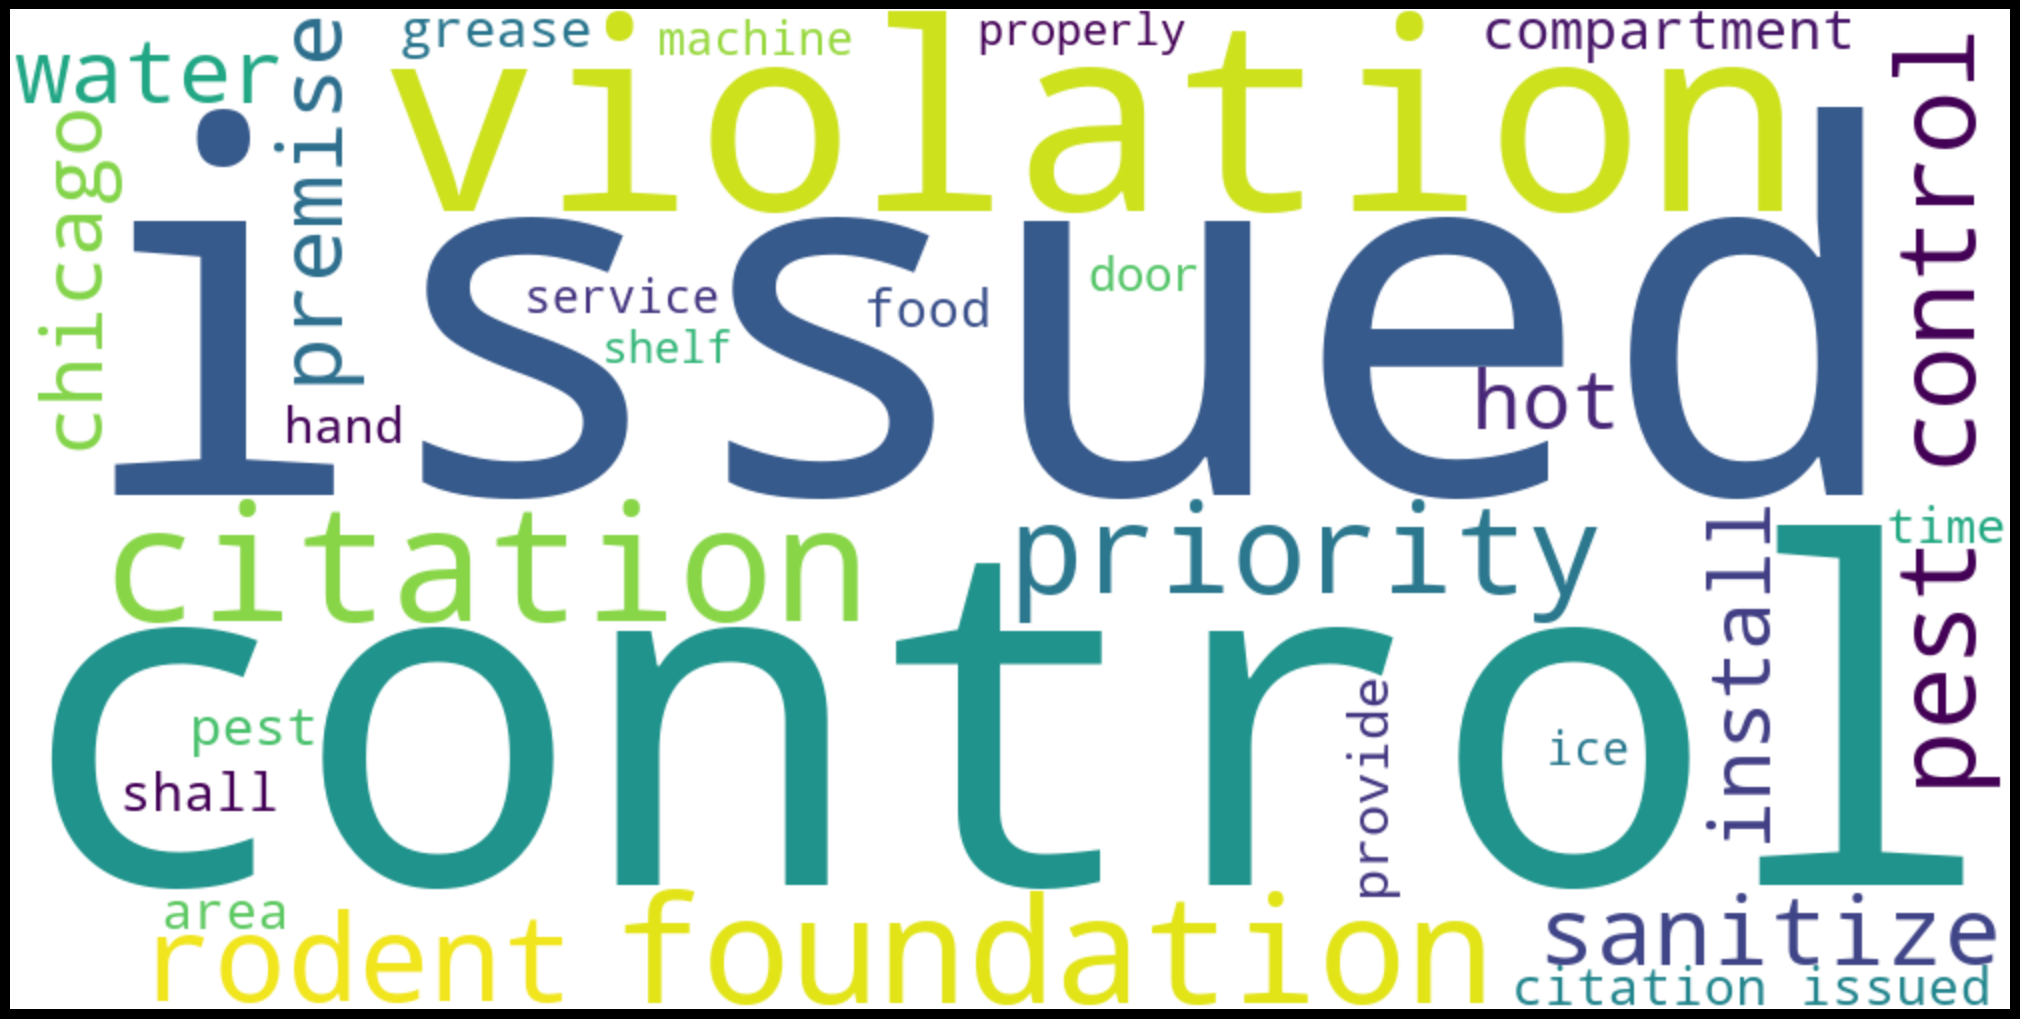

In [182]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
clddata = dict(zip(coefs_with_fns_df_lr['feature'].tolist(),(coefs_with_fns_df_lr['coefficient']*-10).tolist()))

wordcloud_obj= wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)
wordcloud_obj.generate_from_frequencies(clddata)
fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

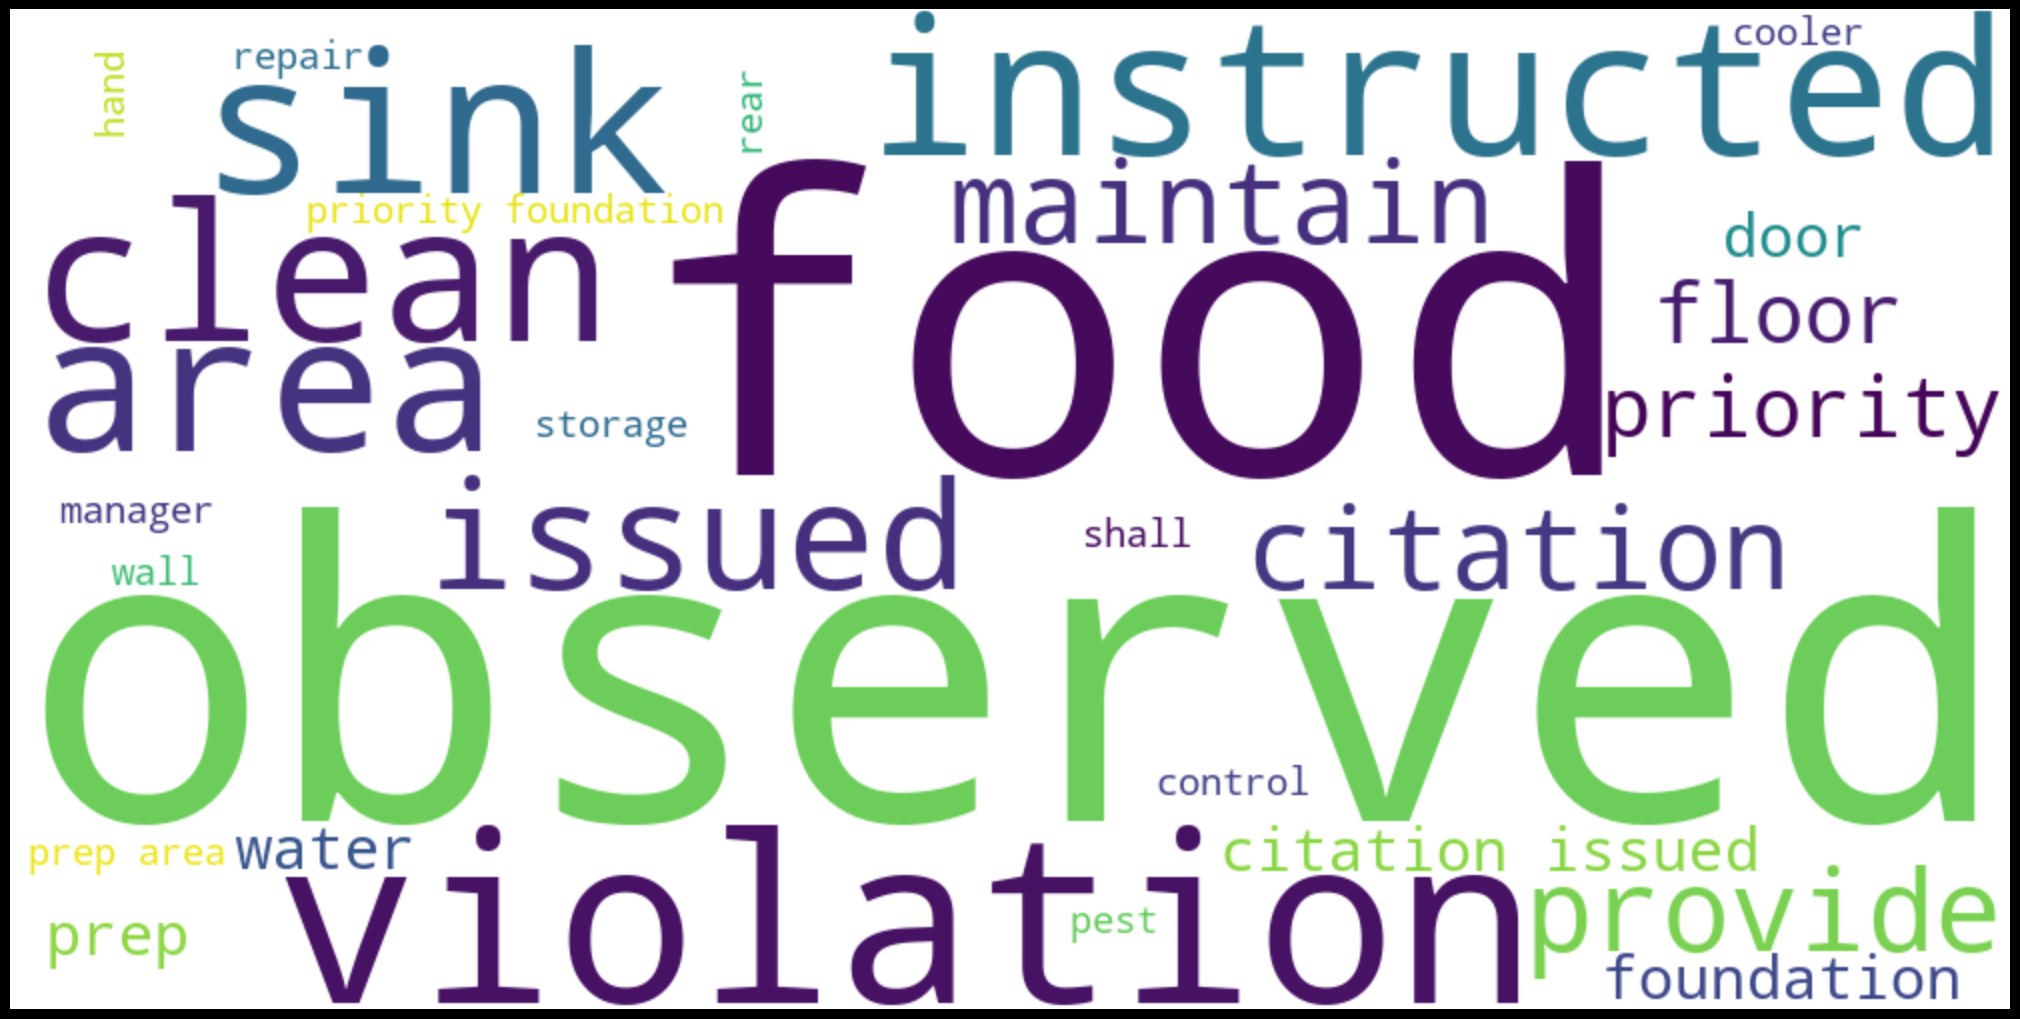

In [183]:

top_features_df1 = coefs_with_fns_df_lr
top_features_df1['coefficient'] = top_features_df1['coefficient']*(10)

data = dict(zip(coefs_with_fns_df['feature'].tolist(), (coefs_with_fns_df['coefficient']*10).tolist()))


wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(data)

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [184]:
coefs_with_fns_df[:10]

,feature,coefficient
44,food,-3.669079
80,observed,-3.693012
127,violation,-3.707645
61,instructed,-3.723163
0,area,-3.800437
107,sink,-3.990894
12,clean,-4.058291
67,issued,-4.091670
92,provide,-4.109487
10,citation,-4.112973


In [185]:
X_test_df = pd.DataFrame(X_test)
X_test_df.reset_index(inplace=True, drop=True)

y_test_df = pd.DataFrame(y_test)
y_test_df.reset_index(inplace=True, drop=True)

In [186]:


# Assuming 'logreg_classifier' is the Logistic Regression classifier
y_pred_prob_lr = logreg_classifier.predict_proba(X_test1)
y_pred_class_lr = logreg_classifier.predict(X_test1)


# Create DataFrames for Logistic Regression
y_pred_prob_df_lr = pd.DataFrame(y_pred_prob_lr, columns=['0-prob', '1-prob'])
y_pred_class_df_lr = pd.DataFrame(y_pred_class_lr, columns=['predicted_lr'])


results_df_lr = X_test_df.join(y_test_df).join(y_pred_class_df_lr).join(y_pred_prob_df_lr)


In [187]:
results_df_lr

,comments,flag,predicted_lr,0-prob,1-prob
0,observed excessive rust and peeling paint on grease trap box in dish area must remove or paint to make smooth and easily cleanable must maintain same observed crackedmissing tile on corner of doorway between kitchen and dish area must repair and maintain same observed large hole around pipe in upper wall of dish area must fill hole to prevent pest entry observed excessive grease andor dirt build up on wall and ceiling in the following area on wall and ceiling to the left of the ventilation hood in kitchen on the wall under dish machine and exterior upper wall of walk in cooler must detail clean these area must maintain same,1,1,0.158278,0.841722
1,interior of comp sink must be kept clean at all time all food and nonfood contact surface of equipment and all food storage utensil shall be thoroughly cleaned and sanitized daily the comp sink is slowdraining must fix maintain ventilation all plumbing fixture such a toilet sink washbasin etc must be adequately trapped vented and revented and properly connected to the sewer in accordance with the plumbing chapter of the municipal code of chicago and the rule and regulation of the board of health,1,1,0.120552,0.879448
2,clean floor along wall and in all corner in breakroom sale and storage area elevate all bread off floor in rear storage area,1,1,0.012896,0.987104
3,found ice scoop being stored inside a dirty container must store ice scoop in a clean location protected from source of contamination or inside machine with scoop handle out of ice found low water pressure at the handwashing sink in the left unisex restroom must repair,1,1,0.055139,0.944861
4,all food not stored in the original container shall be stored in properly labeled containersmust label dessert cup with nameaddressphone numberingridents all food and nonfood contact equipment and utensil shall be smooth easily cleanable and durable and shall be in good repairmust repair or replace worn door gasket on reach in freezer all food and nonfood contact surface of equipment and all food storage utensil shall be thoroughly cleaned and sanitized dailymust clean deep fryer ice machine the floor shall be constructed per code be smooth and easily cleaned and be kept clean and in good repairmust repair or replace damaged floor tile in dining areamust keep floor dry in basement the wall and ceiling shall be in good repair and easily cleanedmust repair or replace hole in toilet room ...,1,1,0.144936,0.855064
...,...,...,...,...,...
38279,ventilation hood filter with grease build up instructed manager must clean and maintain ventilation hood filter sushi prep area compartment dump sink drain pipe leaking must repair and maintain,1,1,0.082006,0.917994
38280,found no valid city of chicago food service sanitation manager certificate posted on site while timetemperature control for safety food chicken are being prepared and served to the public a valid city of chicago food service sanitation manager certificate must be on site at all time while tc food are prepared and served to the public priority foundation violation citation issued observed readytoeat timetemperature control for safety food tc cooked chicken and cooked beef held for over hour without discard date instructed facility to provide discard date for any readytoeat tc food held for over hour priority foundation violation citation issued found beef thawing in a container of water instructed manager to thaw meat under refrigeration or completely submerged under running water for a...,0,0,0.999999,0.000001
38281,observed no proof of training for all food handler instructed to provide and maintain record at all time,1,1,0.026075,0.973925
38282,observed front entrance door and front entrance outer door not tight fitting or rodent proofed with a more than one inch gap under the front entrance door and about a one inch gap at the bottom around and on the top of the outer entrance door instructed to make both or one of the said front entra

In [188]:
y_pred_prob_nb = nb_classifier.predict_proba(X_test1)
y_pred_class_nb = nb_classifier.predict(X_test1)


# Create DataFrames for Logistic Regression
y_pred_prob_df_nb = pd.DataFrame(y_pred_prob_nb, columns=['0-prob', '1-prob'])
y_pred_class_df_nb = pd.DataFrame(y_pred_class_nb, columns=['predicted_nb'])


results_df_nb = X_test_df.join(y_test_df).join(y_pred_class_df_nb).join(y_pred_prob_df_nb)

results_df_nb

,comments,flag,predicted_nb,0-prob,1-prob
0,observed excessive rust and peeling paint on grease trap box in dish area must remove or paint to make smooth and easily cleanable must maintain same observed crackedmissing tile on corner of doorway between kitchen and dish area must repair and maintain same observed large hole around pipe in upper wall of dish area must fill hole to prevent pest entry observed excessive grease andor dirt build up on wall and ceiling in the following area on wall and ceiling to the left of the ventilation hood in kitchen on the wall under dish machine and exterior upper wall of walk in cooler must detail clean these area must maintain same,1,1,0.168728,0.831272
1,interior of comp sink must be kept clean at all time all food and nonfood contact surface of equipment and all food storage utensil shall be thoroughly cleaned and sanitized daily the comp sink is slowdraining must fix maintain ventilation all plumbing fixture such a toilet sink washbasin etc must be adequately trapped vented and revented and properly connected to the sewer in accordance with the plumbing chapter of the municipal code of chicago and the rule and regulation of the board of health,1,1,0.195141,0.804859
2,clean floor along wall and in all corner in breakroom sale and storage area elevate all bread off floor in rear storage area,1,1,0.182609,0.817391
3,found ice scoop being stored inside a dirty container must store ice scoop in a clean location protected from source of contamination or inside machine with scoop handle out of ice found low water pressure at the handwashing sink in the left unisex restroom must repair,1,1,0.242659,0.757341
4,all food not stored in the original container shall be stored in properly labeled containersmust label dessert cup with nameaddressphone numberingridents all food and nonfood contact equipment and utensil shall be smooth easily cleanable and durable and shall be in good repairmust repair or replace worn door gasket on reach in freezer all food and nonfood contact surface of equipment and all food storage utensil shall be thoroughly cleaned and sanitized dailymust clean deep fryer ice machine the floor shall be constructed per code be smooth and easily cleaned and be kept clean and in good repairmust repair or replace damaged floor tile in dining areamust keep floor dry in basement the wall and ceiling shall be in good repair and easily cleanedmust repair or replace hole in toilet room ...,1,1,0.102344,0.897656
...,...,...,...,...,...
38279,ventilation hood filter with grease build up instructed manager must clean and maintain ventilation hood filter sushi prep area compartment dump sink drain pipe leaking must repair and maintain,1,1,0.175838,0.824162
38280,found no valid city of chicago food service sanitation manager certificate posted on site while timetemperature control for safety food chicken are being prepared and served to the public a valid city of chicago food service sanitation manager certificate must be on site at all time while tc food are prepared and served to the public priority foundation violation citation issued observed readytoeat timetemperature control for safety food tc cooked chicken and cooked beef held for over hour without discard date instructed facility to provide discard date for any readytoeat tc food held for over hour priority foundation violation citation issued found beef thawing in a container of water instructed manager to thaw meat under refrigeration or completely submerged under running water for a...,0,0,0.996370,0.003630
38281,observed no proof of training for all food handler instructed to provide and maintain record at all time,1,1,0.312859,0.687141
38282,observed front entrance door and front entrance outer door not tight fitting or rodent proofed with a more than one inch gap under the front entrance door and about a one inch gap at the bottom around and on the top of the outer entrance door instructed to make both or one of the said front entra

In [189]:
results_review_df_lr = results_df_lr[(results_df_lr['0-prob'] < 0.6) & (results_df_lr['1-prob'] < 0.6)]
results_review_df_lr.shape

(1384, 5)

In [190]:
results_review_df_nb = results_df_nb[(results_df_nb['0-prob'] < 0.6) & (results_df_nb['1-prob'] < 0.6)]
results_review_df_nb.shape

(2672, 5)


LR achieves a higher accuracy of 94% compared to NB's 87%.LR has fewer instances with low confidence predictions (1384 instances) compared to NB (2672 instances). Lower instances of low confidence predictions suggest that LR is more confident and decisive in its classifications. Lofistic Regression demonstrates superior accuracy and appears to make predictions with more confidence, making it the more robust model in this context.